In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

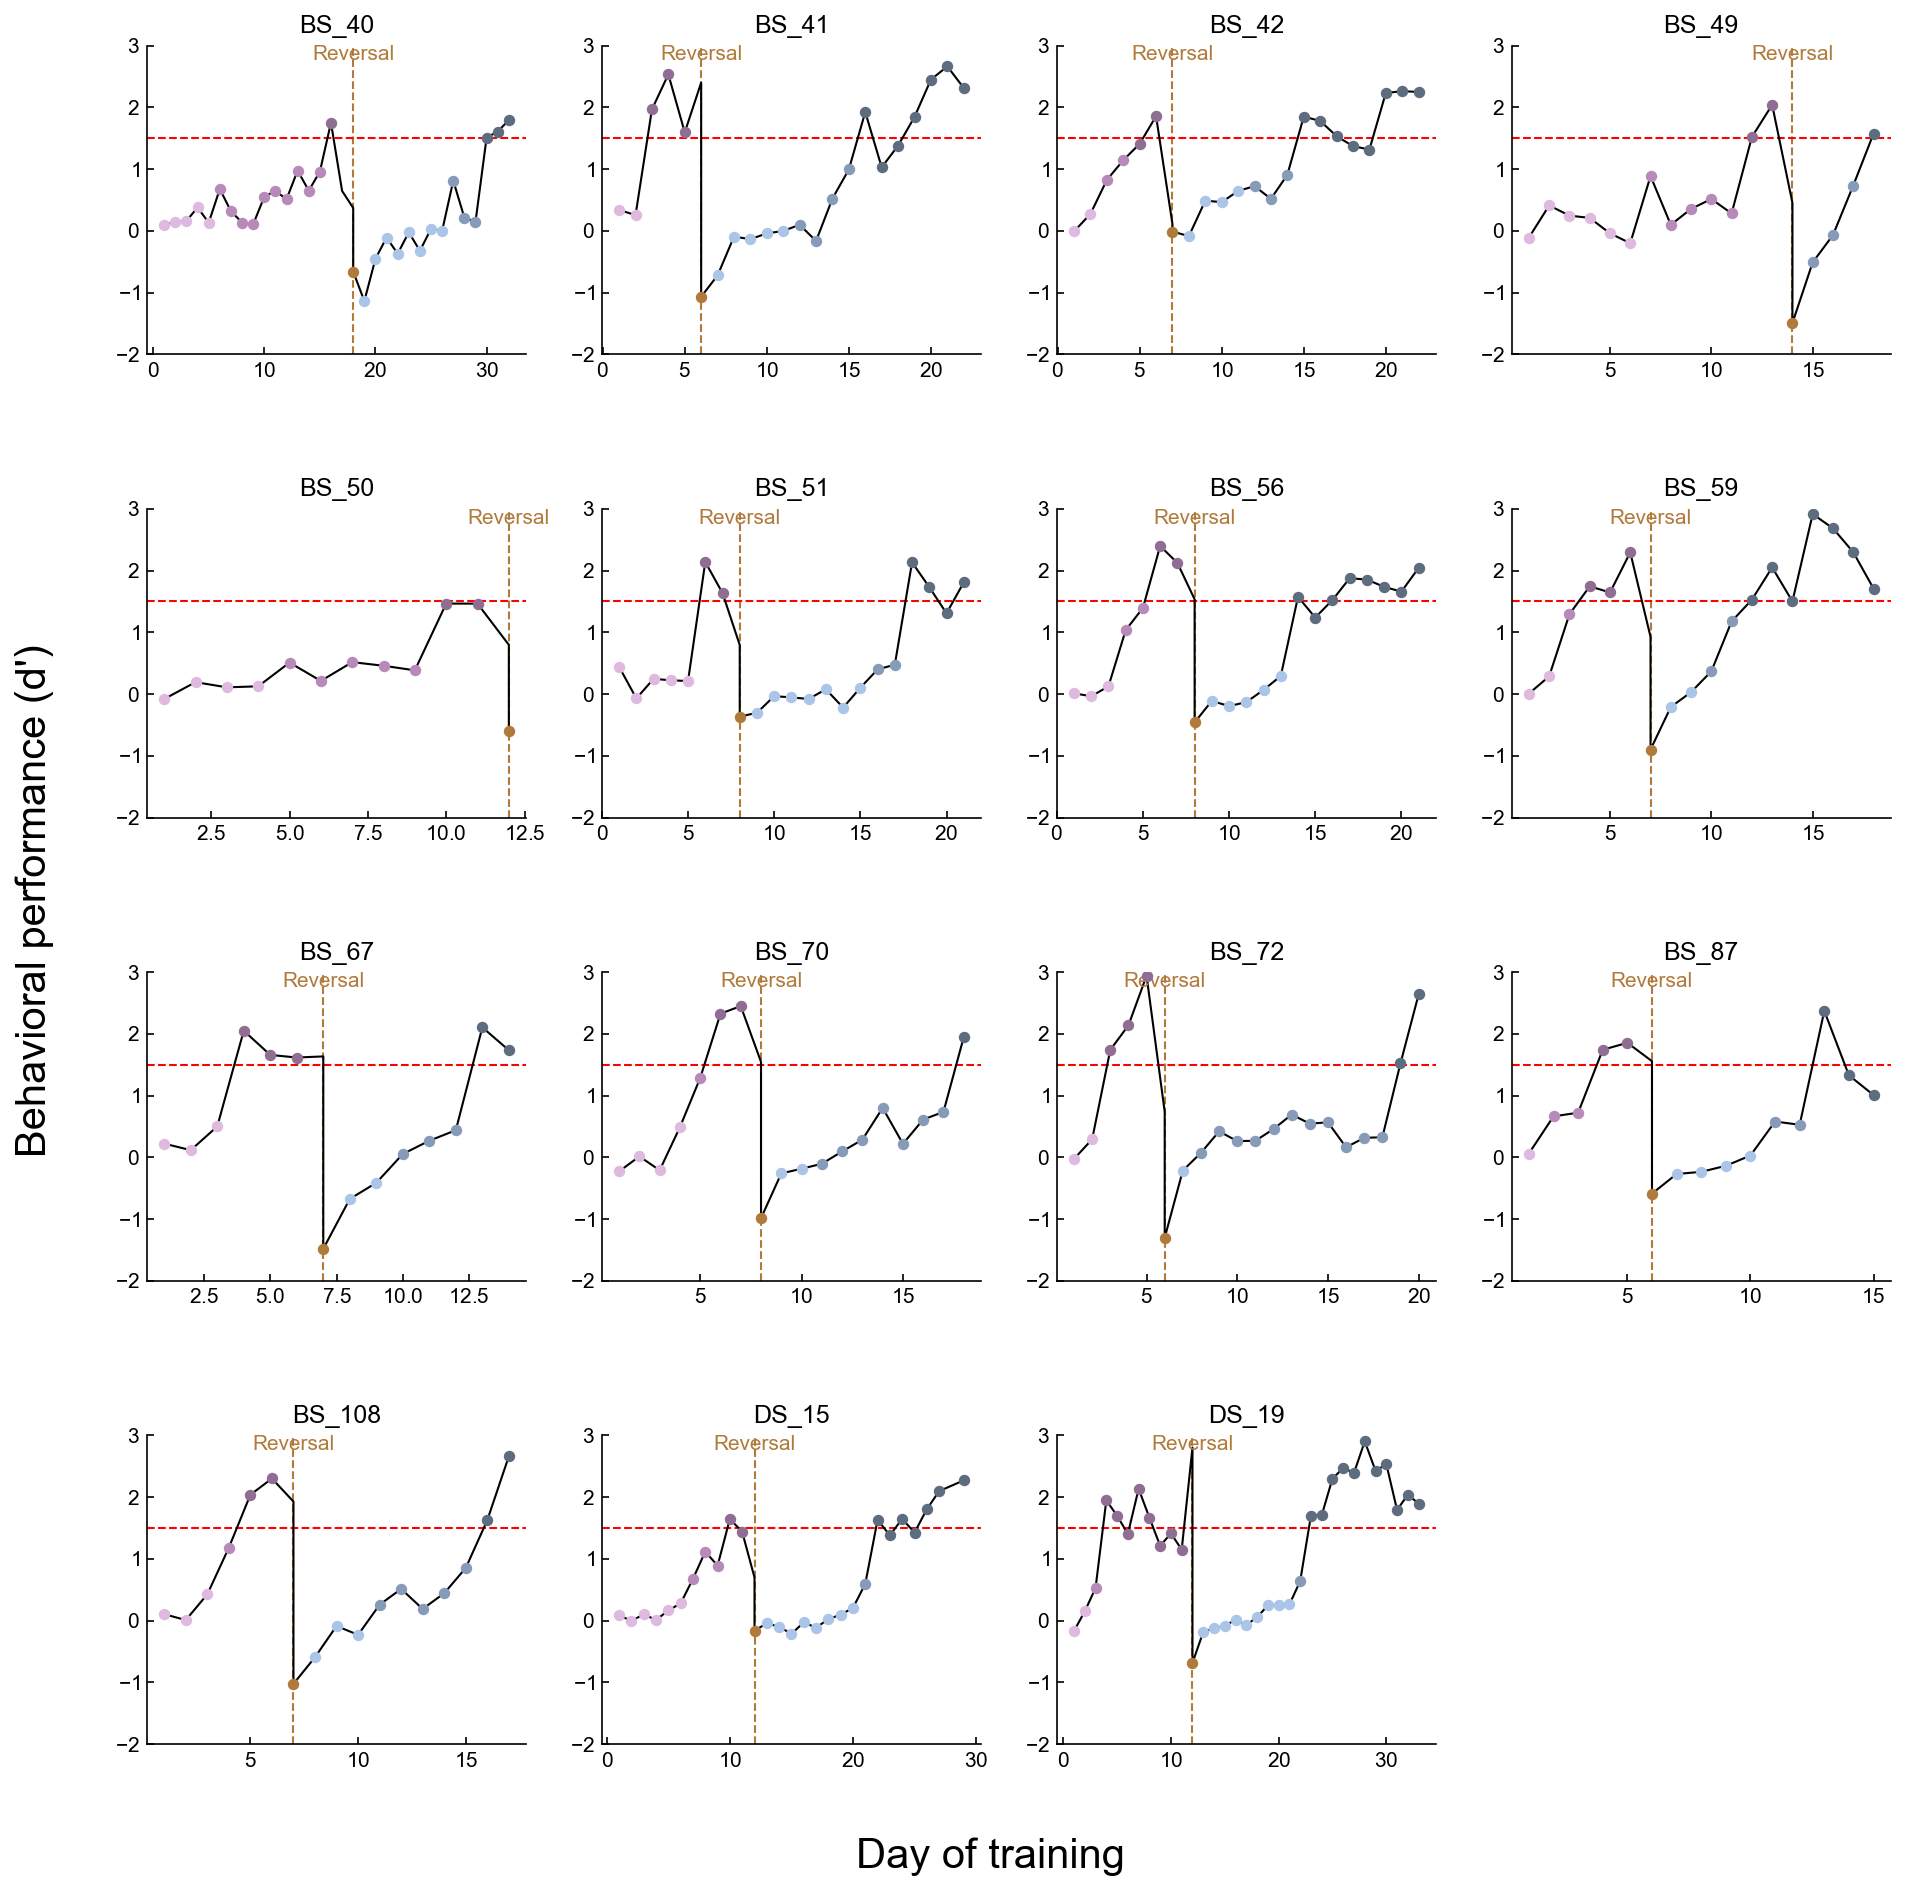

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1830/1830 [00:27<00:00, 66.90it/s] 

errors for: []


In [7]:
np.unique(EILphases)

array(['nan', 'post early', 'post expert', 'post late', 'pre early',
       'pre expert', 'pre late', 'switch'], dtype='<U18')

In [15]:
keyPoints = dict()
phases = ['post early', 'post expert', 'post late', 'pre early','pre expert', 'pre late']#, 'switch']

for phase in phases:
    
    print(phase)
    
    phase_ramping = []
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
        if hasattr(sessionfile.responsiveness[clust]['go'],'rampingSlopePerSec'):
            rampingSlopePerSec = sessionfile.responsiveness[clust]['go'].rampingSlopePerSec
        else:
            rampingSlopePerSec = np.nan

        if EILphases[idx] == phase:
            phase_ramping.append(rampingSlopePerSec)
    phase_ramping = np.array(phase_ramping)    

    print(phase_ramping)
    
    phase_ramping_mask_1 = np.isfinite(phase_ramping)
    phase_ramping_mask_2 = np.greater_equal(phase_ramping,0)
    phase_ramping_mask = np.logical_and(phase_ramping_mask_1,phase_ramping_mask_2)
    phase_ramping = phase_ramping[phase_ramping_mask]

    if len(phase_ramping) > 10:
        pcts = np.percentile(phase_ramping,[20,45,55,90])
        keyPoints[phase] = [0,pcts[0]],[pcts[1],pcts[2]],[pcts[3],np.Inf]
    else:
        print('Not enough data. Taking default values')
        keyPoints[phase] = [0,2.5],[2.5,4.5],[4.5,np.Inf]

11it [00:00, 100.89it/s]

post early


1830it [00:26, 68.36it/s] 
13it [00:00, 115.02it/s]

[            nan -1.21309627e+00             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  3.18016701e+00
 -2.57882405e+00 -8.39607167e+00  8.38736493e+00  8.10247417e+00
             nan             nan  2.13727306e+01  1.05371303e+01
             nan -3.92404843e+00 -1.53686021e+00             nan
             nan -6.36580

1830it [00:26, 68.28it/s] 
13it [00:00, 112.04it/s]

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

1830it [00:26, 68.24it/s] 
13it [00:00, 113.01it/s]

[ -8.02906379  -5.49260432   1.22065692  -2.79806075   8.96894572
   8.8302175   -7.15330462          nan  -0.34324212          nan
   0.9443017   -3.02802418  17.63385878  -0.85774948   0.55800455
          nan          nan  19.75654205  -0.85402641  -1.87044575
  -4.86331572   6.10741891          nan  -4.23224603   1.22958696
          nan          nan          nan  -3.97916525  -2.11653882
  -8.43622885  -2.38967643  -2.84634148  -2.62511411   6.63322415
  -4.92286575  -7.23140374  -7.05895363  -6.15440849 -17.61478192
   0.33092187   0.8126694   -4.22557807   1.76856167   2.39762663
   4.89987062   3.92697617  -7.26130814  -0.36742403          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          

1830it [00:26, 68.54it/s] 
13it [00:00, 104.81it/s]

[ -4.15568072  -4.12149895  -2.19210721   4.3450253   -8.47755166
  11.38918223  -3.35915133   0.16807256   1.9422384    2.87769552
   0.17200648   5.04629276  -3.44110224  -5.29215721   0.06974803
  -4.41448812  -2.81812899  -4.32796078  -0.93727943  -2.01813957
  -1.20357735  -2.35578754   0.09304764  -6.0438349    0.90854589
  -3.14051648   2.31975222 -18.36329531   0.29458463   8.25831285
  -1.78327221   0.37414279  -7.02488535   2.99286239          nan
  -0.437461    -2.28503043   0.82421079  -1.91869881  -5.13480514
  -1.69080907 -11.24562904   3.35341207  -2.78557577          nan
   2.20731511  -2.50611889  -0.51172705   1.39316608          nan
  -6.00115664          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          

1830it [00:26, 68.38it/s] 
13it [00:00, 116.05it/s]

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          

1830it [00:26, 68.43it/s] 

[            nan             nan             nan -3.33726479e+01
  1.16525657e+01             nan  1.02638773e+01  1.56542350e+00
 -7.44563138e-01 -3.31260738e+00 -9.72649091e+00 -8.87631403e+00
 -6.61150192e+00  1.46541248e+00  1.31562105e+01 -9.58885524e-01
             nan             nan  1.56001341e+01  1.81331876e+00
 -8.81192870e-01             nan             nan             nan
  2.30098530e+01 -5.78057858e+00             nan  3.75987039e+00
  1.31227356e+01  6.76607302e+00 -3.89481867e+00             nan
  2.76868054e+01 -2.32455414e-01  8.99200275e+00  6.94904752e+01
 -1.70860647e+01  8.43543489e+00  1.06765919e+01             nan
             nan             nan  2.97069592e+01 -1.27854046e+01
             nan             nan             nan  5.46925086e+00
             nan  1.00152291e+00  2.71469186e+00             nan
  3.50699993e+00  9.44063729e+00             nan             nan
  1.65441198e+01  6.99584365e+00             nan  6.76211963e+01
  1.97394596e+01  7.40547

In [16]:
keyPoints

{'post early': ([0, 1.4489568130630437],
  [4.086830536679682, 5.496481497899514],
  [18.35831302236512, inf]),
 'post expert': ([0, 2.5], [2.5, 4.5], [4.5, inf]),
 'post late': ([0, 0.9443017043473778],
  [2.1993580138079563, 3.63764663094617],
  [13.850433069530027, inf]),
 'pre early': ([0, 0.24555337195183177],
  [1.4480733147142169, 2.180807441894971],
  [5.688696780133006, inf]),
 'pre expert': ([0, 2.5], [2.5, 4.5], [4.5, inf]),
 'pre late': ([0, 3.190076699431857],
  [7.3749936192514305, 9.019302805656972],
  [27.566082036559962, inf])}

In [17]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [18]:
def visualizeClusterInternal(sessionfile,clust,ax1,ax2):

    starttime = -250
    endtime = starttime+2500#1500
    bw_scott_factor = 3

    buffer = 500
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    #fig = plt.figure(figsize=(4,6))
    #gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    #ax1 = plt.subplot(gs[0,0])#Raster
    #ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    response_times = get_response_times_with_default(sessionfile)
    
    

    #Sort trials by response time
    trialsToPlot = np.array(sessionfile.trim[clust].trimmed_trials)
    Is_trialsToPlot_Go = sessionfile.trials.go[trialsToPlot]
    trialsToPlotGo = trialsToPlot[Is_trialsToPlot_Go]
    trialsToPlotNogo = np.logical_not(Is_trialsToPlot_Go)

    #Sort by response time
    response_times_trimmed = response_times[trialsToPlot] - sessionfile.trials.starts[trialsToPlot]#sessionfile.trials.response[trialsToPlot] - sessionfile.trials.starts[trialsToPlot]
    sort_idx = np.argsort(response_times_trimmed)    
    trialsToPlot = trialsToPlot[sort_idx]###
    response_times_trimmed_sorted = response_times_trimmed[sort_idx] * 1000 / sessionfile.meta.fs###

    Go_times_trimmed = response_times - sessionfile.trials.starts
    Go_times_trimmed[np.logical_not(sessionfile.trials.go)] = np.nan * 1000 / sessionfile.meta.fs
    Go_times_trimmed_sorted = Go_times_trimmed[sort_idx]###
    
    new_go_trials_idx_list = np.where(np.isin(trialsToPlot,trialsToPlotGo))[0]
    new_go_trials = trialsToPlot[np.isin(trialsToPlot,trialsToPlotGo)]
    new_go_trials_time_list = Go_times_trimmed[new_go_trials] * 1000 / sessionfile.meta.fs
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)

    #if sessionfile.meta.task == 'switch':
    #    try:
    #        switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
    #        ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
    #    except:
    #        pass
        
    #np.isfinite(Go_times_trimmed_sorted[idx]):
    go_trials = new_go_trials_idx_list
    ax1.scatter(new_go_trials_time_list,go_trials,marker='o',fc='k',ec='k',zorder=-1,s=1.5,label='response')
    
    ax1.fill_betweenx(range(len(trialsToPlot)),[0]*len(trialsToPlot),[100]*len(trialsToPlot),alpha=0.125,color='k',lw=0,label='stimulus')

    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500,2000])
    ax2.set_xticklabels(['0','0.5','1','1.5','2.0'])
    ax2.set_xlabel('Time (s)')
    
    #ax1.set_title(f"Stim. mod.: {sessionfile.responsiveness[clust]['all_trials'].FRmodulation}\nChoice mod.: {sessionfile.responsiveness[clust]['slow_go_response'].rampingMod}")
    ax1.set_title(f"Stim. mod.: {sessionfile.responsiveness[clust]['all_trials'].FRmodulation}\nChoice mod.: {sessionfile.responsiveness[clust]['go'].rampingMod}")

In [19]:
def visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2):
    #starttime = -250
    #endtime = 250
    bw_scott_factor = 3

    #buffer = 500
    #bufferedstart = starttime - buffer
    #bufferedend = endtime + buffer
    #startbuffer = (0-bufferedstart)/1000
    #endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #if not hasattr(sessionfile.responsiveness[clust]['go_response'],'rampingMod'):
    #    continue

    #########################################################################################

    #Determine FRmod category
    #FRmodCategory = 'ERROR'
    #FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    #if FRmod < 2:
    #    FRmodCategory = 'NCR'
    #elif FRmod > 8:
    #    FRmodCategory = 'CR'
    #else:
    #    FRmodCategory = 'Middle'
    ##Skip unidentified category neurons
    #if FRmodCategory == 'ERROR':
    #    continue

    #region = sessionfile.meta.region

    #EIL = EILphases[idx]
    ##Skip unidentified phase neurons
    #if EIL in ['ERROR']:
    #    continue

    #if EIL != 'pre late':
    #    continue

    
    
    
    #This is just the response time of each trial
    response_times = get_response_times_with_default(sessionfile)
    #response_times = sessionfile.trials.response

    #if np.mean(np.isnan(response_times)) > 0.75:
    #    print('skipping '+session+', not enough go responses')
    #    continue

    #plt.hist(sessionfile.trials.response-sessionfile.trials.starts,bins=100)
    #print(sessionfile.trials.response-sessionfile.trials.starts)
    #########################################################################################

    #fig = plt.figure(figsize=(4,6))
    #gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    #ax1 = plt.subplot(gs[0,0])#Raster
    #ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    #Sort trials by response time
    trialsToPlot = np.array(sessionfile.trim[clust].trimmed_trials)
    Is_trialsToPlot_Go = sessionfile.trials.go[trialsToPlot]
    trialsToPlotGo = trialsToPlot[Is_trialsToPlot_Go]
    trialsToPlotNogo = np.logical_not(Is_trialsToPlot_Go)

    response_times_trimmed = response_times[trialsToPlot] - sessionfile.trials.starts[trialsToPlot]#sessionfile.trials.response[trialsToPlot] - sessionfile.trials.starts[trialsToPlot]
    sort_idx = np.argsort(response_times_trimmed)
    trialsToPlot = trialsToPlot[sort_idx]###
    response_times_trimmed_sorted = response_times_trimmed[sort_idx] * 1000 / sessionfile.meta.fs###

    Go_times_trimmed = response_times - sessionfile.trials.starts
    Go_times_trimmed[np.logical_not(sessionfile.trials.go)] = np.nan
    Go_times_trimmed_sorted = Go_times_trimmed[sort_idx] * 1000 / sessionfile.meta.fs###
    Go_times_trimmed_sorted = Go_times_trimmed_sorted[np.isfinite(Go_times_trimmed_sorted)]
    
    new_go_trials_idx_list = np.where(np.isin(trialsToPlot,trialsToPlotGo))[0]

    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=response_times[trial]-2.75*sessionfile.meta.fs,endtime=response_times[trial]+0.25*sessionfile.meta.fs)
        this_trial_spikes = this_trial_spikes - response_times[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        ##this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        #trialend = response_times[trial]
        ##trialstart = trialend - 2.5*sessionfile.meta.fs
        #trialstart = sessionfile.trials.starts[trial]
        #
        #trialstart_buffer = trialstart - 0.25*30000
        #trialend_buffer = trialend + 0.25*30000
        #
        #this_trial_idx = np.logical_and(np.greater(clustSpikes,trialstart_buffer) , np.less(clustSpikes,trialend_buffer))
        #this_trial_spikes = clustSpikes[this_trial_idx] - trialend
        #
        #this_trial_spikes = this_trial_spikes*1000/30000
        #

        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)

        trialend = response_times[trial]
        trialstart = sessionfile.trials.starts[trial]
        trial_duration = trialend-trialstart
        trial_duration = trial_duration * 1000 / 30000

        #ax1.plot([-2500,-trial_duration],[idx,idx],color='red',lw=0.1)

    #np.isfinite(Go_times_trimmed_sorted[idx]):
    #print(Go_times_trimmed_sorted)
    #go_trials = np.where(np.isfinite(Go_times_trimmed_sorted))[0]
    go_trials = new_go_trials_idx_list
    ax1.scatter(np.zeros_like(go_trials),go_trials,marker='o',fc='k',ec='k',zorder=-1,s=1.5,label='response')

    
    ax1.fill_betweenx(range(len(trialsToPlot)),-response_times_trimmed_sorted,100-response_times_trimmed_sorted,alpha=0.125,color='k',lw=0,label='stimulus')
    
    #ax1.axvline(0,lw=2.5,color='green',label='Response')
    ax1.legend(frameon=False,loc=(0.6,1))

    #if EIL == 'switch':
    #    try:
    #        switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
    #        ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
    #    except:
    #        pass

    #Plot PSTH
    starttime = -2500
    endtime = 0
    PSTHstart = starttime - 500
    PSTHend = endtime + 500
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    #ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    #ax2.set_xticks([0,500,1000,1500])
    #ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xticks([-0,-500,-1000,-1500,-2000,-2500])
    ax2.set_xticklabels(['0','-0.5','-1','-1.5','-2.0','-2.5'])
    ax2.set_xlabel('Time relative to response (s)')


    #p_ev,p_sup,p_ncr = calculate_NCR_CR_pval(sessionfile,clust)
    #category = 'Inconclusive'
    #rampingMod = sessionfile.responsiveness[clust]['go_response'].rampingMod
    #if p_ev > 0.95 or p_sup > 0.95:
    #    rampingMod = sessionfile.responsiveness[clust]['slow_go_response'].rampingMod
    #    if np.abs(sessionfile.responsiveness[clust]['slow_go_response'].rampingModNorm > 0.5):
    #        category = 'Both'
    #    else:
    #        category = 'Stimulus'
    #elif p_ncr > 0.95:
    #    if np.abs(sessionfile.responsiveness[clust]['go_response'].rampingModNorm > 0.5):
    #        category = 'Ramping'
    #    else:
    #        category = 'NCR'

    #if hasattr(sessionfile.responsiveness[clust]['go_response'],'rampingMod'):
    #    ax1.set_title(f"Category: {category}\nStimulus: {sessionfile.responsiveness[clust]['all_trials'].FRmodulation}\nRamping: {rampingMod}")
    #else:
    #    ax1.set_title(f"Ramping not calculated")

    #try:
    #    if not FRmodCategory == 'ERROR':
    #        fig.savefig(os.path.join('D:\\\\TempFigures','ChoiceRasters',region,FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    #        fig.savefig(os.path.join('D:\\\\TempFigures','ChoiceRasters',region,FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    #    fig.savefig(os.path.join('D:\\\\TempFigures','ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    #    fig.savefig(os.path.join('D:\\\\TempFigures','ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    #except Exception as e:
    #    print(e)

1830it [4:39:21,  9.16s/it]


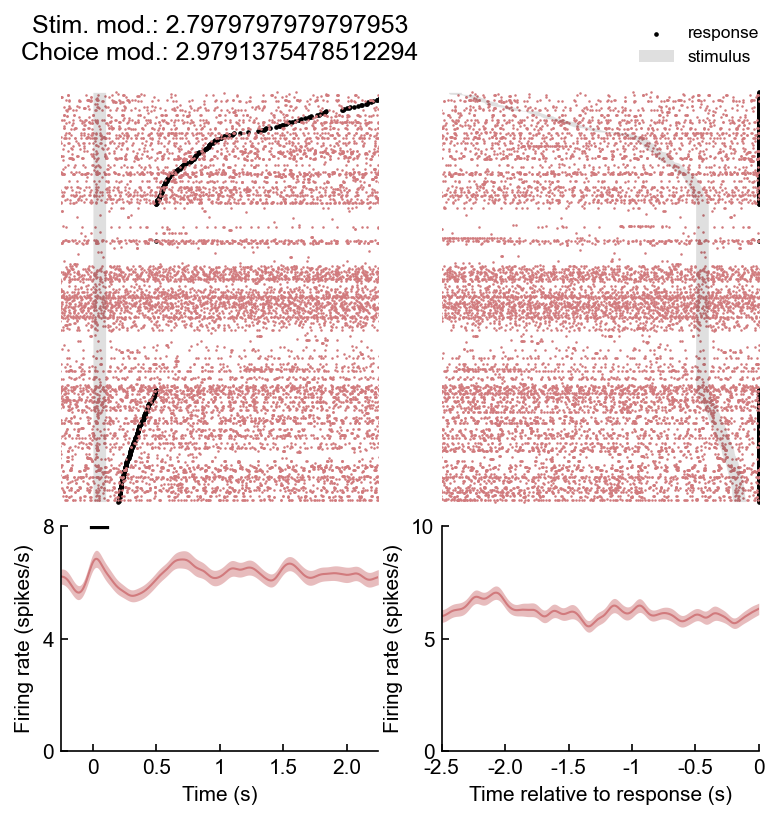

In [25]:
try:
    os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\pdfs')
    os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\pngs')
except:
    pass
for phase in phases:
    try:
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase)
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\high')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\middle')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\low')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\high\\pngs')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\middle\\pngs')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\low\\pngs')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\high\\pdfs')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\middle\\pdfs')
        os.mkdir('D:\\\\TempFigures\\Example Ramping cells\\'+phase+'\\low\\pdfs')
    except Exception as e:
        print(e)

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    phase = EILphases[idx]
    
    plt.close('all')
    
    if phase not in phases:
        continue
    
    ramping = sessionfile.responsiveness[clust]['go'].rampingSlopePerSec
    
    if ramping >= keyPoints[phase][0][0] and ramping <= keyPoints[phase][0][1]:
        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
        ax1 = plt.subplot(gs[0,0])#Raster
        ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

        ax3 = plt.subplot(gs[0,1])#Raster
        ax4 = plt.subplot(gs[1,1],sharex=ax3)#PSTH

        visualizeClusterInternal(sessionfile,clust,ax1,ax2)
        visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4)
        
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'low','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'low','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
        
    elif ramping >= keyPoints[phase][1][0] and ramping <= keyPoints[phase][1][1]:
        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
        ax1 = plt.subplot(gs[0,0])#Raster
        ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

        ax3 = plt.subplot(gs[0,1])#Raster
        ax4 = plt.subplot(gs[1,1],sharex=ax3)#PSTH

        visualizeClusterInternal(sessionfile,clust,ax1,ax2)
        visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4)
        
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'middle','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'middle','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
        
    elif ramping >= keyPoints[phase][2][0] and ramping <= keyPoints[phase][2][1]:
        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
        ax1 = plt.subplot(gs[0,0])#Raster
        ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

        ax3 = plt.subplot(gs[0,1])#Raster
        ax4 = plt.subplot(gs[1,1],sharex=ax3)#PSTH

        visualizeClusterInternal(sessionfile,clust,ax1,ax2)
        visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4)
        
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'high','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
        fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells',phase,'high','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
        
    
    fig = plt.figure(figsize=(6,6))
    gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax3)#PSTH

    visualizeClusterInternal(sessionfile,clust,ax1,ax2)
    visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4)
    fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Example Ramping cells','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")